# Standard ICEPACK-DART Case Analysis

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import glob
import seaborn as sns

In [2]:
def open_data(case):
    
    data_dir1 = '/glade/work/mollyw/Projects/icepack_da/assim_data/'+case+'/'
    fore = xr.open_dataset(data_dir1 + '/forecasted_ensemble.nc')
    infl = xr.open_dataset(data_dir1 + '/inflated_ensemble.nc')
    filt = xr.open_dataset(data_dir1 + '/filtered_ensemble.nc')
    proc = xr.open_dataset(data_dir1 + '/postprocessed_ensemble.nc')
    fem = xr.open_dataset(data_dir1 + '/forecasted_ensemble_mean.nc')
    
    if len(fore.time) > len(filt.time):
        fore = fore.resample(time='1D').mean()
        fore = fore.isel(time=slice(0,364))
        fore['time'] = filt.time
        fore = fore.drop('ni')
    
    if len(fem.time) > len(filt.time):
        fem = fem.resample(time='1D').mean()
        fem = fem.isel(time=slice(0,364))
        fem['time'] = filt.time
    
    return fore, infl, filt, proc, fem

In [3]:
def open_data2(case):
    
    data_dir1 = '/glade/work/mollyw/Projects/icepack_da/assim_data/'+case+'/'
    proc = xr.open_dataset(data_dir1 + '/postprocessed_ensemble.nc')
    
#     if len(fore.time) > len(filt.time):
#         fore = fore.resample(time='1D').mean()
#         fore = fore.isel(time=slice(0,364))
#         fore['time'] = filt.time
#         fore = fore.drop('ni')
    
#     if len(fem.time) > len(filt.time):
#         fem = fem.resample(time='1D').mean()
#         fem = fem.isel(time=slice(0,364))
#         fem['time'] = filt.time
    
    return proc

In [4]:
def weighting(case, fore, filt, fem, variable):
    
    baseline_adj = xr.open_dataset('/glade/work/mollyw/Projects/icepack_da/notebooks/'+case+'_baseline_adjustments_for_weighting.nc')
    
    diff = abs(filt[variable] - fore[variable])
    adj = diff/fem[variable]
    
    weighting = baseline_adj[variable]/adj
    weighting = weighting.mean(dim='time')
    
    return weighting

In [5]:
def percent_violating(da, bounds):
    
    if len(bounds) > 1:
        upper = (da > bounds[1]).sum(dim='time')
        lower = (da < bounds[0]).sum(dim='time')
        number = upper + lower
    else:
        number = (da < bounds[0]).sum(dim='time')
    
    # mem_perc = number/len(da.time) * weight
    # percent = mem_perc.sum(dim='member')/len(da.member) * 100
    percent = number.sum(dim='member')/(len(da.time)*len(da.member)) * 100 
   
    
    return percent

In [6]:
def get_bars(case_list, variable):
    
    VAL = []
    if variable == 'aice':
        bounds  = [0, 1]
    else:
        bounds = [0]
    
    for case in case_list:
        # print('Working on ', case, '...')
        fore, infl, filt, proc, fem = open_data(case)
        # weight = weighting('SIT_f101_BNRH_cice', fore, filt, fem, variable)
        val = percent_violating(filt[variable], bounds) 
        VAL.append(val.values)
    
    return VAL

In [7]:
def get_observations(obs_dir, catwise = False):

    # collate observation sequence files 
    if catwise is True:
        files = sorted(glob.glob(obs_dir + '/itd/obs_seq.2011*'))
        obs_types = ['SAT_SEAICE_VICE01','SAT_SEAICE_VICE02','SAT_SEAICE_VICE03','SAT_SEAICE_VICE04','SAT_SEAICE_VICE05', 
                     'SAT_SEAICE_AICE01','SAT_SEAICE_AICE02','SAT_SEAICE_AICE03','SAT_SEAICE_AICE04','SAT_SEAICE_AICE05']
    else:
        files = sorted(glob.glob(obs_dir + '/obs_seq.2011*'))
        obs_types = ['SAT_SEAICE_AGREG_FREEBOARD', 'SAT_SEAICE_AGREG_CONCENTR','SAT_SEAICE_AGREG_THICKNESS']
    
    print('Collecting ' + str(len(files)) + ' days of observations...')

    nfiles = len(files)
    nobs = len(obs_types)
    obs = np.zeros((nfiles, nobs))
    truths = obs.copy()
    time = []
   

    # cycle through files 
    for nfile, filename in enumerate(files):
        with open(filename) as f:
            lines = f.readlines()

        time_str = filename[-8:]
        date = datetime.strptime(time_str, '%Y%m%d')
        time.append(date)
       # for each open files, look for the obs info
        count = 0 
        for num, line in enumerate(lines):
            # check if the line is the top of the OBS information
            if line.find('OBS') != -1:
                lnum = lines.index(line)
                obs[nfile,count] = lines[num+1].strip()
                truths[nfile,count] = lines[num+2].strip()
                count += 1
  
    obs_da = xr.DataArray(obs, coords = [time, obs_types], dims = ['time','nobs'], name = 'observations')
    truths_da = xr.DataArray(truths,coords = [time, obs_types], dims = ['time','nobs'], name = 'truths')
    ds = xr.Dataset(data_vars = dict(obs = (['time','nobs'],obs_da.data),
                                         truths = (['time','nobs'],truths_da.data),),
                                         coords = dict(time = time, nobs = obs_types),
                                         attrs = dict(description = 'observations and truths for data assimilation experiments in Icepack')
                    )
    return ds 

In [198]:
case_list = ['SIT_f1_NORM_cice', 'SIT_f101_NORM_cice',
             #'SIC_f1_NORM_cice', 'SIC_f101_NORM_cice', 'SIC_f1_BNRH_cice', 'SIC_f101_BNRH_cice',
             'AGR_f1_NORM_cice', 'AGR_f101_NORM_cice',
             'VIC_f1_NORM_cice', 'VIC_f101_NORM_cice',
             'AIC_f1_NORM_vice', 'AIC_f101_NORM_cice',
             'CAT_f1_NORM_cice', 'CAT_f101_NORM_cice',
            ]

In [201]:
bars = get_bars(case_list, 'aice')
bars = np.reshape(bars, (5,2))

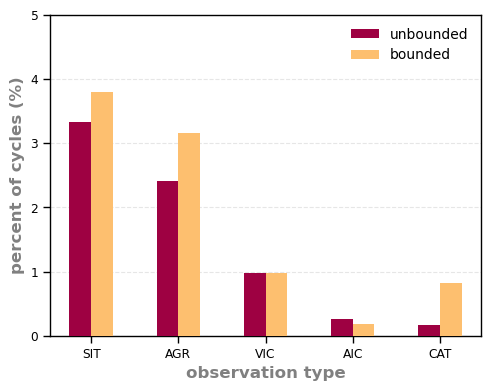

In [216]:
plt.figure(figsize=(5,4))
plt.grid(axis='y', color = '0.9', linestyle='dashed', zorder=0)
colors = plt.cm.get_cmap('Spectral', np.shape(bars)[1]+2)

n = np.shape(bars)[1]
w = .25
x = np.arange(0, np.shape(bars)[0]) 
names = ['SIT', 'AGR', 'VIC', 'AIC', 'CAT']#'SIT', 'SIC', 
filts = ['unbounded', 'bounded']

for i in range(0, np.shape(bars)[1]):
    position = x + (w*(1-n)/2) + i*w
    plt.bar(position, bars[:,i], width = w, label = filts[i], color = colors(i)[:3], zorder = 3)

plt.xticks(np.arange(0,np.shape(bars)[0]), labels = names)
plt.ylim([0,5])
plt.ylabel('percent of cycles (%)', fontweight='bold', fontsize=12, color = 'grey')
plt.xlabel('observation type', fontweight='bold', fontsize=12, color = 'grey')
plt.legend(fontsize=10, ncol=1, loc = 'upper right', frameon=False)
# plt.title('Percent of Cycles Violating SIC Bounds', fontweight='bold', fontsize=12)

plt.tight_layout()

In [78]:
bars = get_bars(case_list, 'vsnon')
bars = np.reshape(bars, (6,4,5))

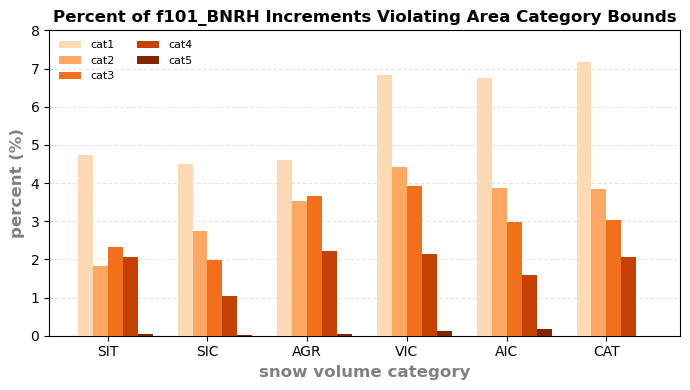

In [79]:
plt.figure(figsize=(7,4))
plt.grid(axis='y', color = '0.9', linestyle='dashed', zorder=0)
colors = plt.cm.get_cmap('Oranges', np.shape(bars)[2]+1)

n = np.shape(bars)[1]
w = .15
x = np.arange(0, np.shape(bars)[0]) 
names = ['SIT','SIC', 'AGR', 'VIC','AIC', 'CAT']
filts = ['cat1','cat2','cat3','cat4','cat5']

for i in range(0, np.shape(bars)[2]):
    position = x + (w*(1-n)/2) + i*w
    plt.bar(position, bars[:,0,i], width = w, label = filts[i], color = colors(i+1)[:3], zorder=3)

plt.xticks(np.arange(0,np.shape(bars)[0]), labels = names)
plt.ylim([0,8])
plt.ylabel('percent (%)', fontweight='bold', fontsize=12, color = 'grey')
plt.xlabel('snow volume category', fontweight='bold', fontsize=12, color = 'grey')
plt.legend(fontsize=8, ncol=2, loc = 'upper left', frameon=False)
plt.title('Percent of f101_BNRH Increments Violating Area Category Bounds', fontweight='bold', fontsize=12)
plt.tight_layout()

In [18]:
def get_baseline_adj(case):
    fore, infl, filt, proc, fem = open_data(case)
    diff = abs(filt-fore)
    weights = diff/fem
    
    weights.to_netcdf(case+'_baseline_adjustments_for_weighting.nc')
    return weights

In [19]:
weights = get_baseline_adj('SIT_f101_BNRH_cice')
weights = get_baseline_adj('SIT_f1_BNRH_cice')
weights = get_baseline_adj('SIT_f101_NORM_cice')
weights = get_baseline_adj('SIT_f1_NORM_cice')

### Errors

In [8]:
def calculate_error_bounds(case):
    
    data_dir1 = '/glade/work/mollyw/Projects/icepack_da/assim_data/'+case+'/'
    
    pem = xr.open_dataset(data_dir1 + '/postprocessed_ensemble_mean.nc')
    psd = xr.open_dataset(data_dir1 + '/postprocessed_ensemble_sd.nc')
    
    upperbound = pem + psd
    lowerbound = pem - psd
    
    return upperbound, lowerbound, pem

In [157]:
aggreg_obs = get_observations('/glade/work/mollyw/DA_obs/ICEPACK_OBS/free_SHEBA/eakf_vs_brhf/mem_14/bc_obs/', catwise=False)
data = open_data2('unassimilated')

/glade/scratch/mollyw/ipykernel_208044/2530109546.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=35)


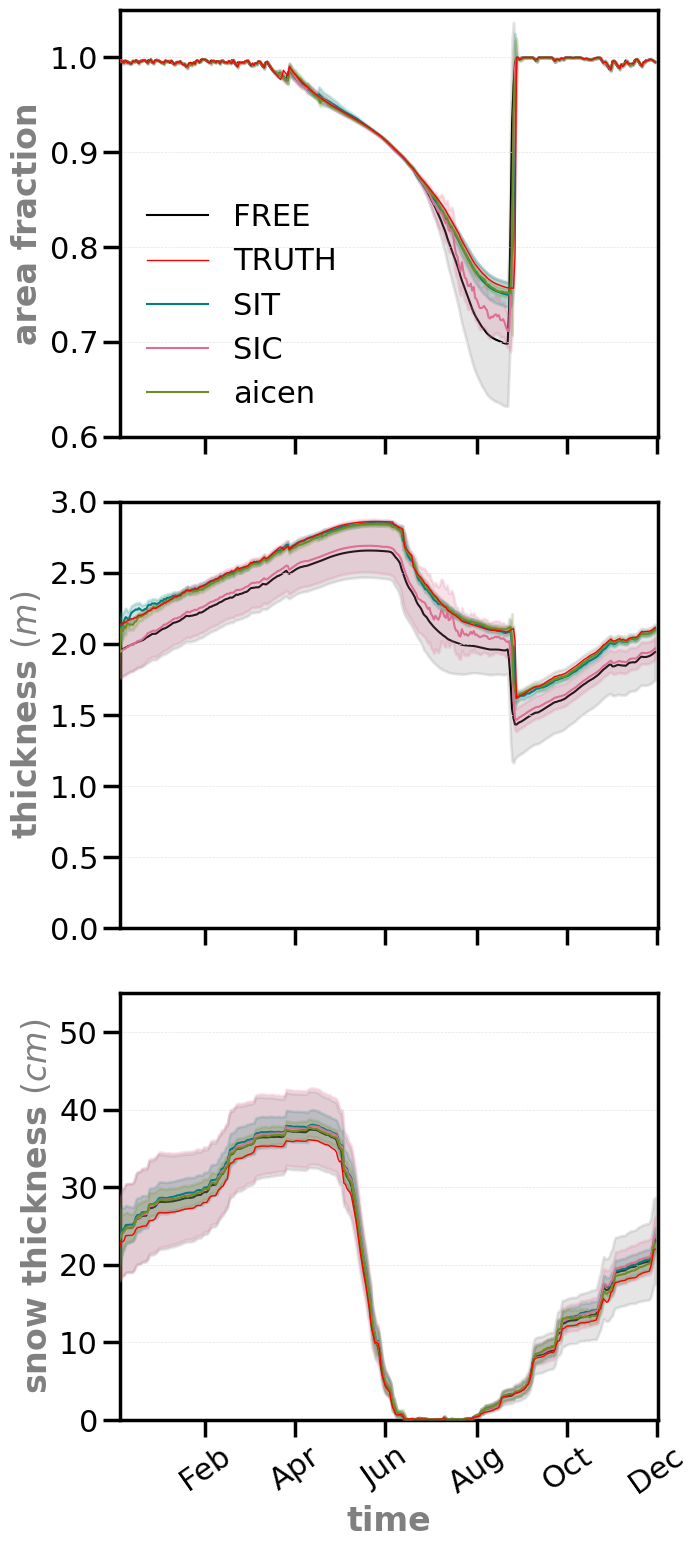

In [167]:
sns.set_context('poster')
fig, axes = plt.subplots(nrows = 3, figsize = (7.5,16))

case_list = ['SIT_f1_NORM_cice','SIC_f1_NORM_cice','AIC_f1_NORM_catwise']

colors = ['teal','palevioletred','olivedrab']
labels = ['SIT','SIC','aicen']

axes[0].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[1].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[2].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)

x = aggreg_obs.time.values
fup, flw, fem = calculate_error_bounds('unassimilated')
axes[0].fill_between(x, flw.aice, fup.aice, alpha=0.2, color = 'grey')
axes[0].plot(x, fem.aice, c = 'black', label = 'FREE',linewidth = 1.5, zorder = 1)
# axes[0].plot(aggreg_obs.obs[:,1], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
axes[0].plot(x, aggreg_obs.truths[:,1], c = 'red', linewidth = 1, label = 'TRUTH', zorder = 5)

axes[1].fill_between(x, flw.hi, fup.hi, alpha=0.2, color = 'grey')
axes[1].plot(x, fem.hi, c = 'black', linewidth = 1.5, zorder = 1)
# axes[1].plot(aggreg_obs.obs[:,0], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
axes[1].plot(x, aggreg_obs.truths[:,0], c = 'red', linewidth = 1, zorder = 5)

axes[2].fill_between(x, flw.vsnon.sum(dim='ncat')*100, fup.vsnon.sum(dim='ncat')*100, alpha=0.2, color = 'grey')
axes[2].plot(x, fem.vsnon.sum(dim='ncat')*100, c = 'black',linewidth = 1.5, zorder = 1)
# axes[1].plot(aggreg_obs.obs[:,0], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
axes[2].plot(x, data.isel({'member':13}).vsnon.sum(dim='ncat')*100, c = 'red', linewidth = 1, zorder = 5)

count = 0
for case in case_list:
    upperbound, lowerbound, pem = calculate_error_bounds(case)
    axes[0].fill_between(x, lowerbound.aice, upperbound.aice, alpha=0.2, color = colors[count], zorder = 3)
    axes[0].plot(x, pem.aice, c = colors[count],label = labels[count], linewidth = 1.5, zorder = 4)
           
    axes[1].fill_between(x, lowerbound.hi, upperbound.hi, alpha=0.2, color = colors[count], zorder = 3)
    axes[1].plot(x, pem.hi, c = colors[count], linewidth = 1.5, zorder = 4)
    
    axes[2].fill_between(x, lowerbound.vsnon.sum(dim='ncat')*100, upperbound.vsnon.sum(dim='ncat')*100, alpha=0.2, color = colors[count], zorder = 3)
    axes[2].plot(x, pem.vsnon.sum(dim='ncat')*100, c = colors[count], linewidth = 1.5, zorder = 4)
    count +=1 

    
# axes[0].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35)
# axes[1].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[2].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=35)

axes[0].set_ylim([0.6,1.05])
axes[0].set_xlim(['2011-01-02', '2012-01-02'])
# axes[0].set_xlabel('time', fontsize=12, fontweight='bold', color='grey')
axes[0].set_ylabel('area fraction', fontweight='bold', color='grey')
axes[0].legend(frameon=False)

axes[1].set_ylim([0,3])
axes[1].set_xlim(['2011-01-02', '2012-01-02'])
# axes[1].set_xlabel('time', fontsize=12, fontweight='bold', color='grey')
axes[1].set_ylabel('thickness $(m)$', fontweight='bold', color='grey')

axes[2].set_ylim([0,55])
axes[2].set_xlim(['2011-01-02', '2012-01-02'])
axes[2].set_xlabel('time', fontweight='bold', color='grey')
axes[2].set_ylabel('snow thickness $(cm)$', fontweight='bold', color='grey')

plt.tight_layout()

In [168]:
aggreg_obs = get_observations('/glade/work/mollyw/DA_obs/ICEPACK_OBS/free_ATM/eakf_vs_brhf/mem_14/bc_obs/', catwise=False)
data = open_data2('unassimilated_ATM')

/glade/scratch/mollyw/ipykernel_208044/1128955439.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=35)


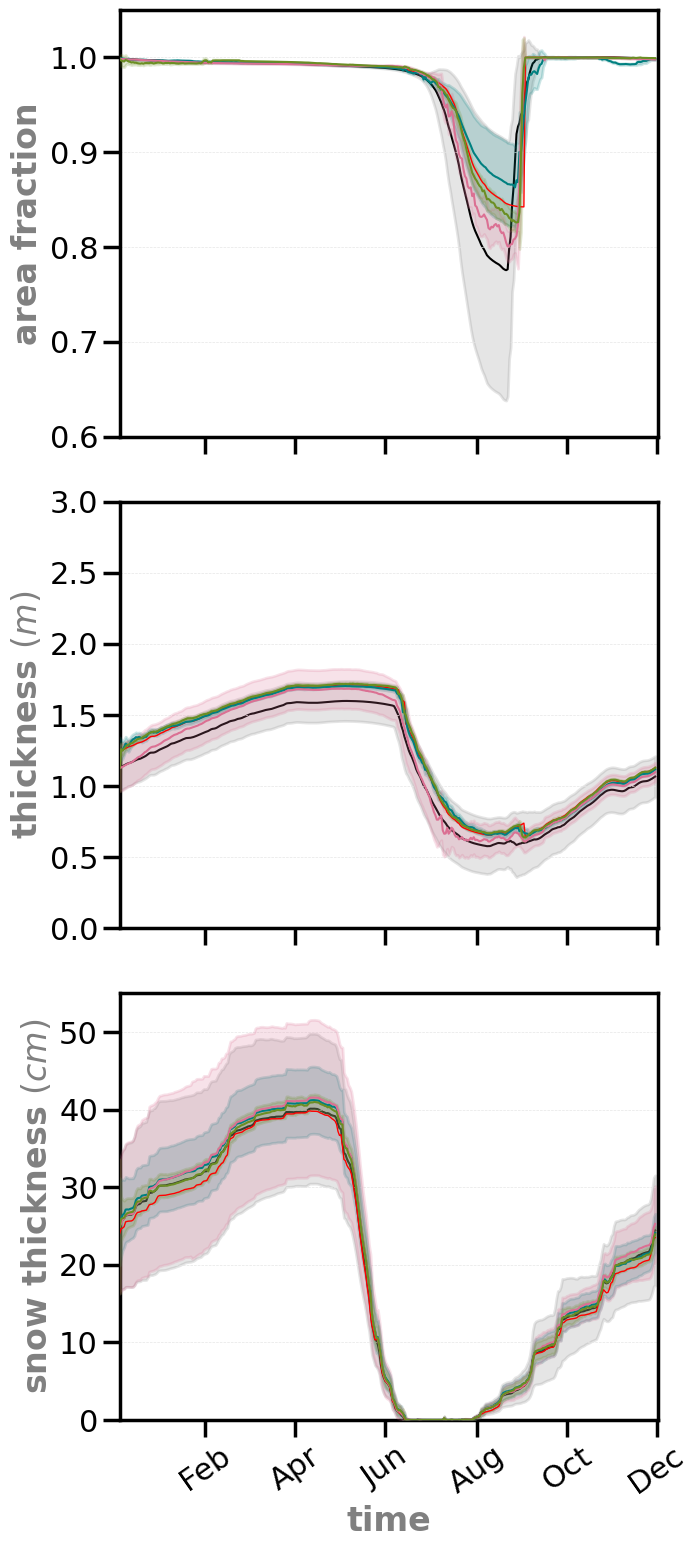

In [169]:
sns.set_context('poster')
fig, axes = plt.subplots(nrows = 3, figsize = (7.5,16))

case_list = ['SIT_f1_NORM','SIC_f1_NORM','AIC_f1_NORM']

colors = ['teal','palevioletred','olivedrab']
labels = ['SIT','SIC','AIC']

axes[0].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[1].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
axes[2].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)

x = aggreg_obs.time.values
fup, flw, fem = calculate_error_bounds('unassimilated_ATM')
axes[0].fill_between(x, flw.aice, fup.aice, alpha=0.2, color = 'grey')
axes[0].plot(x, fem.aice, c = 'black', linewidth = 1.5, label = 'FREE', zorder = 1)
# axes[0].plot(aggreg_obs.obs[:,1], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
axes[0].plot(x, aggreg_obs.truths[:,1], c = 'red', linewidth = 1, label = 'TRUTH', zorder = 4)

axes[1].fill_between(x, flw.hi, fup.hi, alpha=0.2, color = 'grey')
axes[1].plot(x, fem.hi, c = 'black', linewidth = 1.5,zorder = 1)
# axes[1].plot(aggreg_obs.obs[:,0], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
axes[1].plot(x, aggreg_obs.truths[:,0], c = 'red',linewidth = 1, zorder = 4)

axes[2].fill_between(x, flw.vsnon.sum(dim='ncat')*100, fup.vsnon.sum(dim='ncat')*100, alpha=0.2, color = 'grey')
axes[2].plot(x, fem.vsnon.sum(dim='ncat')*100, c = 'black', linewidth = 1.5,zorder = 1)
# axes[1].plot(aggreg_obs.obs[:,0], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
axes[2].plot(x, data.isel({'member':13}).vsnon.sum(dim='ncat')*100, c = 'red',linewidth = 1, zorder = 4)

count = 0
for case in case_list:
    upperbound, lowerbound, pem = calculate_error_bounds(case)
    axes[0].fill_between(x, lowerbound.aice, upperbound.aice, alpha=0.2, color = colors[count], zorder = 3)
    axes[0].plot(x, pem.aice, c = colors[count],label = labels[count], linewidth = 1.5,zorder = 4)
           
    axes[1].fill_between(x, lowerbound.hi, upperbound.hi, alpha=0.2, color = colors[count], zorder = 3)
    axes[1].plot(x, pem.hi, c = colors[count], linewidth = 1.5,zorder = 4)
    
    axes[2].fill_between(x, lowerbound.vsnon.sum(dim='ncat')*100, upperbound.vsnon.sum(dim='ncat')*100, alpha=0.2, color = colors[count], zorder = 3)
    axes[2].plot(x, pem.vsnon.sum(dim='ncat')*100, c = colors[count], linewidth = 1.5,zorder = 4)
    count +=1 

    
# axes[0].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35)
# axes[1].set_xticklabels(labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=35)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[2].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=35)

axes[0].set_ylim([0.6,1.05])
axes[0].set_xlim(['2011-01-02', '2012-01-02'])
# axes[0].set_xlabel('time', fontsize=12, fontweight='bold', color='grey')
axes[0].set_ylabel('area fraction',fontweight='bold', color='grey')
# axes[0].legend(frameon=False)

axes[1].set_ylim([0,3])
axes[1].set_xlim(['2011-01-02', '2012-01-02'])
# axes[1].set_xlabel('time', fontsize=12, fontweight='bold', color='grey')
axes[1].set_ylabel('thickness $(m)$', fontweight='bold', color='grey')

axes[2].set_ylim([0,55])
axes[2].set_xlim(['2011-01-02', '2012-01-02'])
axes[2].set_xlabel('time', fontweight='bold', color='grey')
axes[2].set_ylabel('snow thickness $(cm)$', fontweight='bold', color='grey')

plt.tight_layout()

In [48]:
catwise_obs = get_observations('/glade/work/mollyw/DA_obs/ICEPACK_OBS/free_SHEBA/eakf_vs_brhf/mem_14/bc_obs/', catwise=True)
data = open_data2('unassimilated')

/glade/scratch/mollyw/ipykernel_208044/3777503867.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/3777503867.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/3777503867.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/3777503867.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/3777503867.py:30: UserWarning: FixedFormatter should only be 

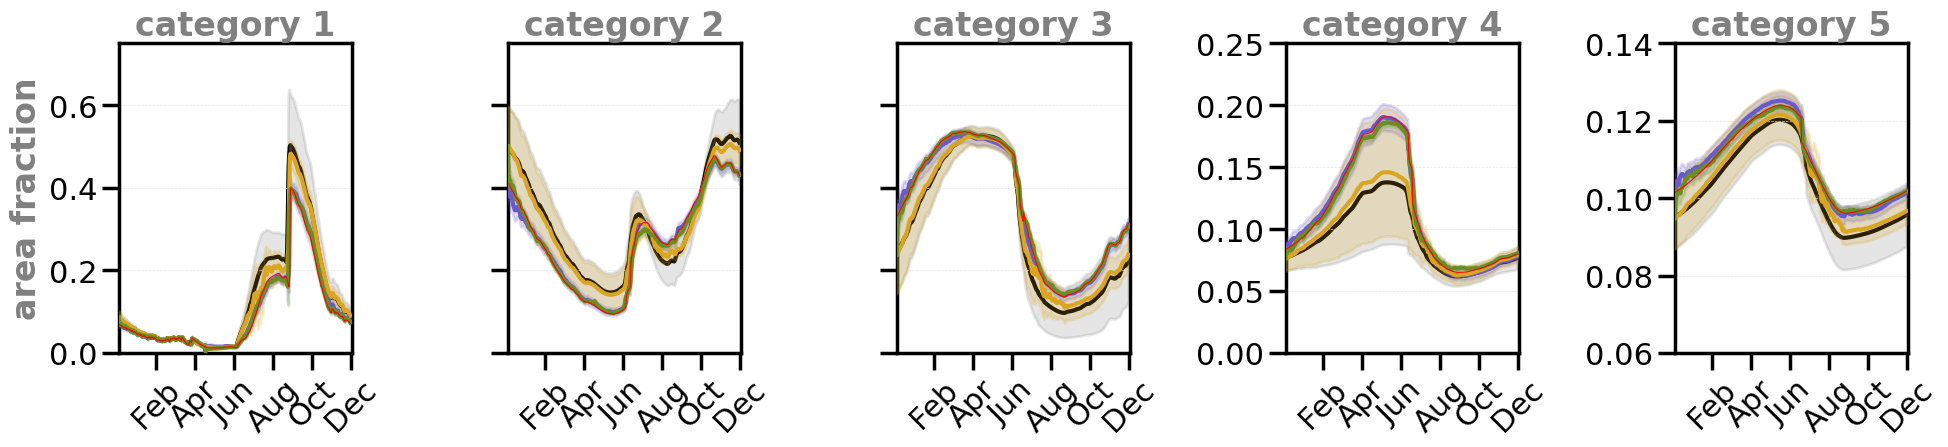

In [78]:
sns.set_context('poster')
fig, axes = plt.subplots(ncols = 5, figsize = (20,5))

case_list = ['SIT_f1_NORM_cice','SIC_f1_NORM_cice','AIC_f1_NORM_catwise']

colors = ['teal','palevioletred','olivedrab']
labels = ['SIT','SIC','aicen']

x = catwise_obs.time.values
fup, flw, fem = calculate_error_bounds('unassimilated')

for y in range(0,5):
    axes[y].fill_between(x, flw.aicen[:,y], fup.aicen[:,y], alpha=0.2, color = 'grey')
    axes[y].plot(x, fem.aicen[:,y], c = 'black', zorder = 1)
    # axes[0].plot(aggreg_obs.obs[:,1], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
    axes[y].plot(x, catwise_obs.truths[:,y+5], c = 'red', linewidth = 0.75,  zorder = 5)

    count = 0
    for case in case_list:
        upperbound, lowerbound, pem = calculate_error_bounds(case)
        axes[y].fill_between(x, lowerbound.aicen[:,y], upperbound.aicen[:,y], alpha=0.2, color = colors[count], zorder = 3)
        axes[y].plot(x, pem.aicen[:,y], c = colors[count], zorder = 4)
        count +=1 

    
    if y in [1,2]:
        axes[y].set_yticklabels([])
        
    # labels = ['Jan','Mar','May','Jul','Sep','Nov','Jan'], rotation=45)
    axes[y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
    
    if y == 3:
        axes[y].set_ylim([0,0.25])
    elif y == 4:
        axes[y].set_ylim([0.06,0.14])
    else:
        axes[y].set_ylim([0, 0.75])
        
    axes[y].set_xlim(['2011-01-02', '2012-01-02'])
    axes[y].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[y].set_title('category '+str(y+1), fontweight='bold', color='grey')
    
axes[0].set_ylabel('area fraction', fontweight='bold', color='grey')
axes[0].legend(frameon=False, loc = 'upper left')
plt.tight_layout()

In [101]:
catwise_obs2 = get_observations('/glade/work/mollyw/DA_obs/ICEPACK_OBS/free_SHEBA/eakf_vs_brhf/mem_14/bc_obs/', catwise=True)
catwise_obs = get_observations('/glade/work/mollyw/DA_obs/ICEPACK_OBS/free_ATM/eakf_vs_brhf/mem_14/bc_obs/', catwise=True)
data = open_data2('unassimilated_ATM')
data2 = open_data2('unassimilated')

/glade/scratch/mollyw/ipykernel_208044/2052129519.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/2052129519.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/2052129519.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/2052129519.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)
/glade/scratch/mollyw/ipykernel_208044/2052129519.py:42: UserWarning: FixedFormatter sho

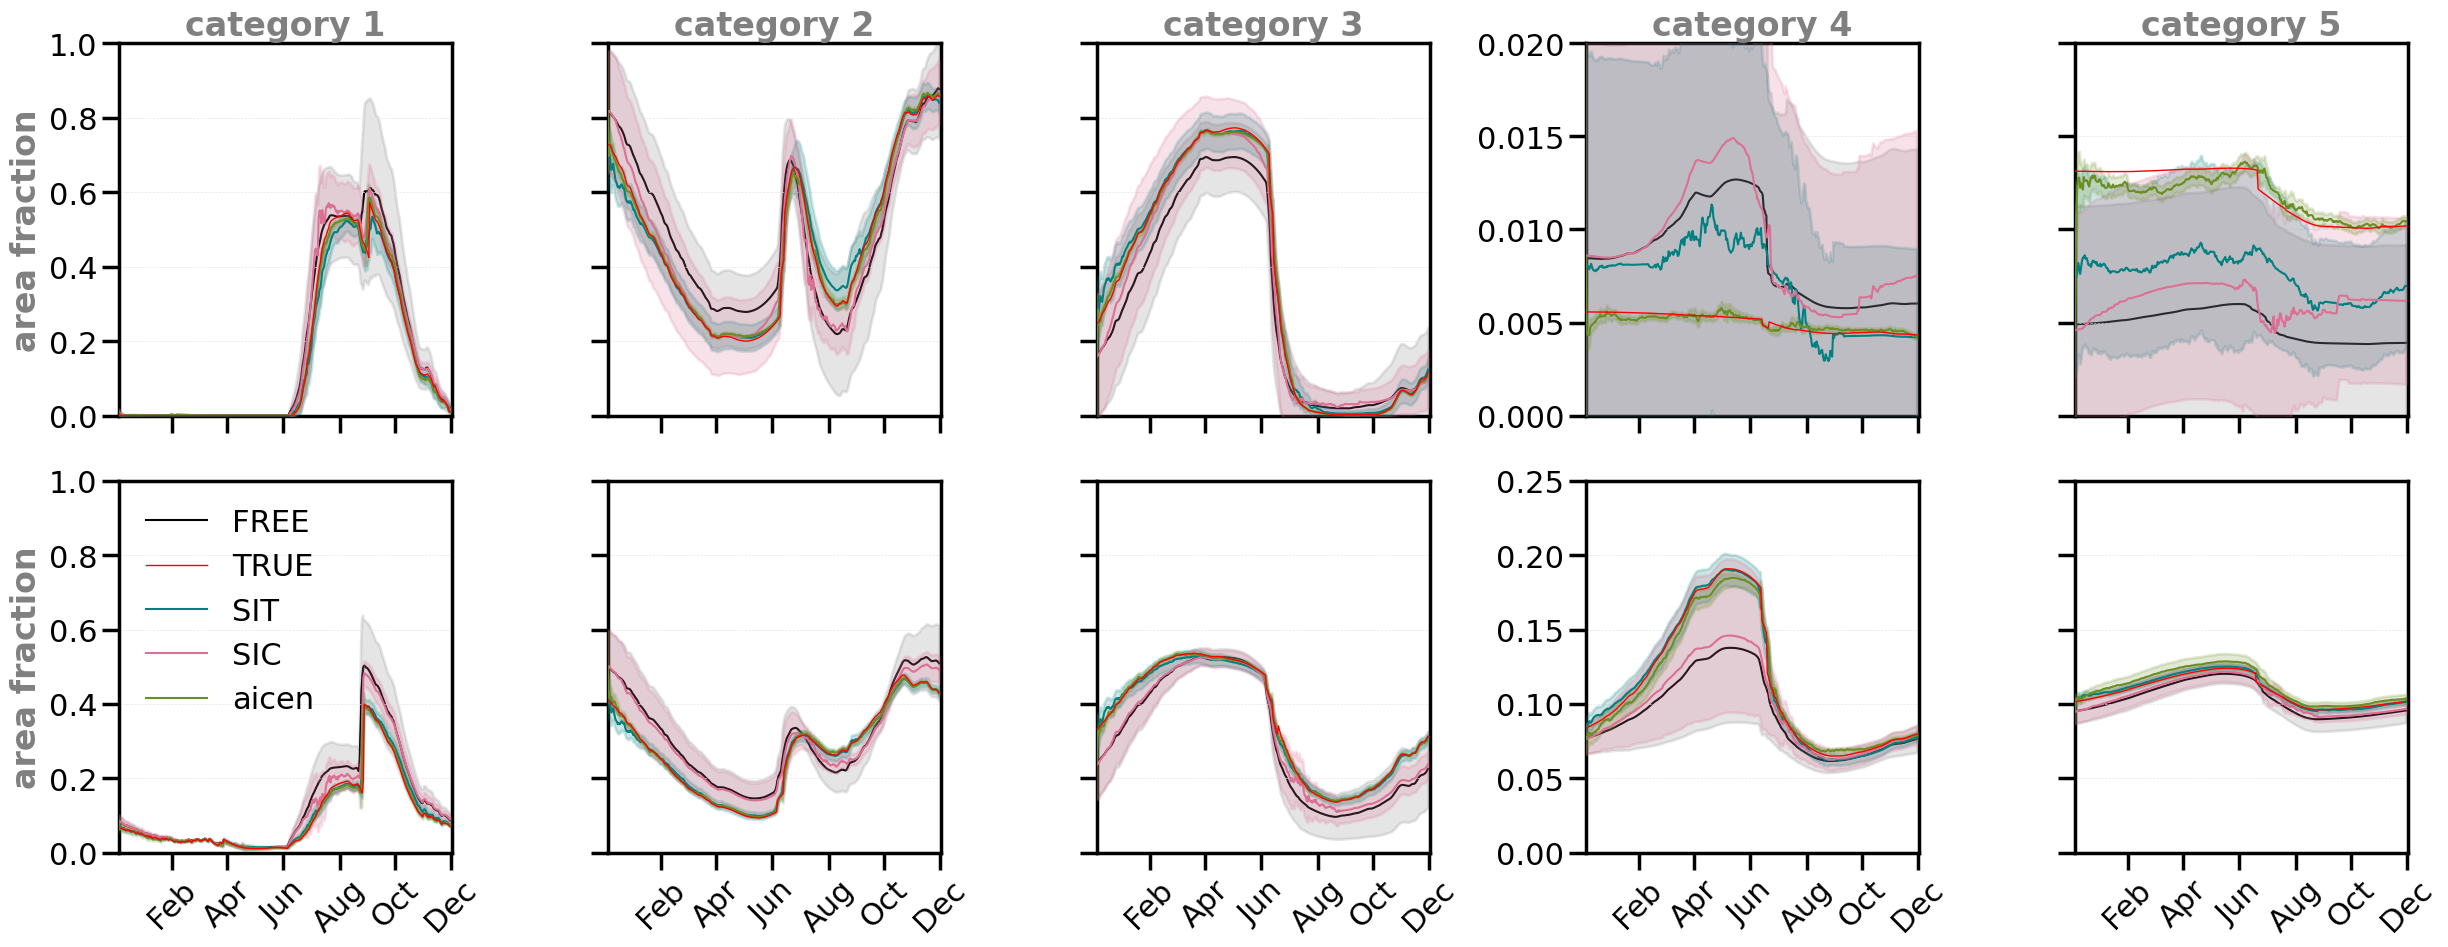

In [171]:
sns.set_context('poster')
fig, axes = plt.subplots(ncols = 5, nrows = 2, figsize = (25,10))

case_list = ['SIT_f1_NORM','SIC_f1_NORM','AIC_f1_NORM']

colors = ['teal','palevioletred','olivedrab']
labels = ['SIT','SIC','aicen']

x = catwise_obs.time.values
fup, flw, fem = calculate_error_bounds('unassimilated_ATM')
fup2, flw2, fem2 = calculate_error_bounds('unassimilated')
for y in range(0,5):
        
    axes[0][y].fill_between(x, flw.aicen[:,y], fup.aicen[:,y], alpha=0.2, color = 'grey')
    axes[0][y].plot(x, fem.aicen[:,y], c = 'black', linewidth = 1.5, zorder = 1)
    # axes[0].plot(aggreg_obs.obs[:,1], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
    axes[0][y].plot(x, catwise_obs.truths[:,y+5], c = 'red', linewidth = 1, zorder = 5)

    axes[1][y].fill_between(x, flw2.aicen[:,y], fup2.aicen[:,y], alpha=0.2, color = 'grey')
    axes[1][y].plot(x, fem2.aicen[:,y], c = 'black', zorder = 1, linewidth = 1.5, label = 'FREE')
    # axes[0].plot(aggreg_obs.obs[:,1], c = 'brown', alpha = 0.1, zorder = 3, linewidth = 0.75)
    axes[1][y].plot(x, catwise_obs2.truths[:,y+5], c = 'red', linewidth = 1, zorder = 5, label = 'TRUE')
    
    count = 0
    for case in case_list:
        upperbound, lowerbound, pem = calculate_error_bounds(case)
        upb2, lwb2, pem2 = calculate_error_bounds(case+'_cice')
        axes[0][y].fill_between(x, lowerbound.aicen[:,y], upperbound.aicen[:,y], alpha=0.2, color = colors[count], zorder = 3)
        axes[0][y].plot(x, pem.aicen[:,y], c = colors[count], linewidth = 1.5, zorder = 4)

        axes[1][y].fill_between(x, lwb2.aicen[:,y], upb2.aicen[:,y], alpha=0.2, color = colors[count], zorder = 3)
        axes[1][y].plot(x, pem2.aicen[:,y], c = colors[count], zorder = 4, linewidth = 1.5,label = labels[count])

        count +=1 

    if y in [1,2,4]:
        axes[0][y].set_yticklabels([])
        axes[1][y].set_yticklabels([])
    # elif y == 4:
    #     axes[y].set_yticklabels([])
    axes[0][y].set_xticklabels([])
    axes[1][y].set_xticklabels(labels = ['Feb','Apr','Jun','Aug','Oct','Dec','Jan'], rotation=45)

    if y < 3:
        axes[0][y].set_ylim([0,1])
        axes[1][y].set_ylim([0,1])
    elif y == 4:
        axes[1][y].set_ylim([0.0,0.25])
        axes[0][y].set_ylim([0.0,0.02])
    else:
        axes[1][y].set_ylim([0.0,0.25])
        axes[0][y].set_ylim([0.0,0.02])
        
    axes[0][y].set_xlim(['2011-01-02', '2012-01-02'])
    axes[1][y].set_xlim(['2011-01-02', '2012-01-02'])

    
    axes[0][y].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[1][y].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[0][y].set_title('category '+str(y+1),fontweight='bold', color='grey')
    
# axes[2].set_xlabel('time',  fontweight='bold', color='grey')
axes[0][0].set_ylabel('area fraction',fontweight='bold', color='grey')
axes[1][0].set_ylabel('area fraction',fontweight='bold', color='grey')
axes[1][0].legend(frameon=False, loc = 'upper left')
plt.tight_layout()

### Covariance Relationships

In [236]:
case_list = ['SIT_f1_NORM_cice', 'SIT_f101_NORM_cice', 'SIT_f1_BNRH_cice', 'SIT_f101_BNRH_cice',
             'SIC_f1_NORM_cice', 'SIC_f101_NORM_cice', 'SIC_f1_BNRH_cice', 'SIC_f101_BNRH_cice',
             'AIC_f1_NORM_vice', 'AIC_f101_NORM_cice', 'AIC_f1_BNRH_cice', 'AIC_f101_BNRH_cice',
             #'VIC_f1_NORM_cice', 'VIC_f101_NORM_cice', 'VIC_f1_BNRH_cice', 'VIC_f101_BNRH_cice'
            ]

In [237]:
INFLATED = []
for case in case_list:
    fore, infl, filt, post, em = open_data(case)
    
    INFLATED.append(infl)

cases = xr.concat(INFLATED, dim = 'case')
cases['case'] = case_list

<AxesSubplot:xlabel='hi', ylabel='aicen'>

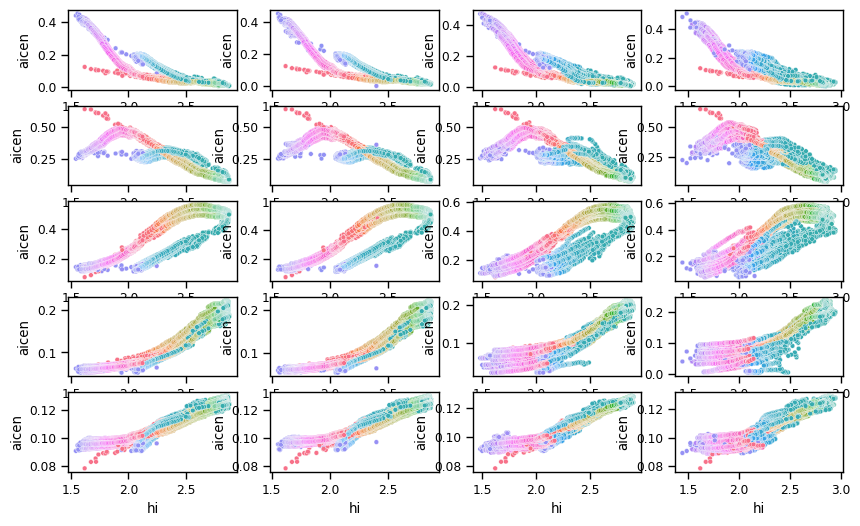

In [238]:
fig, axes = plt.subplots(ncols = 4, nrows = 5, figsize = (10,6))

df = cases.sel({'ncat':0}).to_dataframe()
df = df.reset_index()

sns.scatterplot(data = df[df['case'] == 'SIT_f1_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[0][0])
sns.scatterplot(data = df[df['case'] == 'SIT_f1_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[0][2])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[0][1])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[0][3])

df = cases.sel({'ncat':1}).to_dataframe()
df = df.reset_index()
sns.scatterplot(data = df[df['case'] == 'SIT_f1_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[1][0])
sns.scatterplot(data = df[df['case'] == 'SIT_f1_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[1][2])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[1][1])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[1][3])


df = cases.sel({'ncat':2}).to_dataframe()
df = df.reset_index()
sns.scatterplot(data = df[df['case'] == 'SIT_f1_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[2][0])
sns.scatterplot(data = df[df['case'] == 'SIT_f1_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[2][2])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[2][1])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[2][3])


df = cases.sel({'ncat':3}).to_dataframe()
df = df.reset_index()
sns.scatterplot(data = df[df['case'] == 'SIT_f1_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[3][0])
sns.scatterplot(data = df[df['case'] == 'SIT_f1_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[3][2])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[3][1])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[3][3])


df = cases.sel({'ncat':4}).to_dataframe()
df = df.reset_index()
sns.scatterplot(data = df[df['case'] == 'SIT_f1_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[4][0])
sns.scatterplot(data = df[df['case'] == 'SIT_f1_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[4][2])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_NORM_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[4][1])
sns.scatterplot(data = df[df['case'] == 'SIT_f101_BNRH_cice'], x = 'hi', y ='aicen', hue = 'time', style = 'case', size = 5, legend=False, ax = axes[4][3])


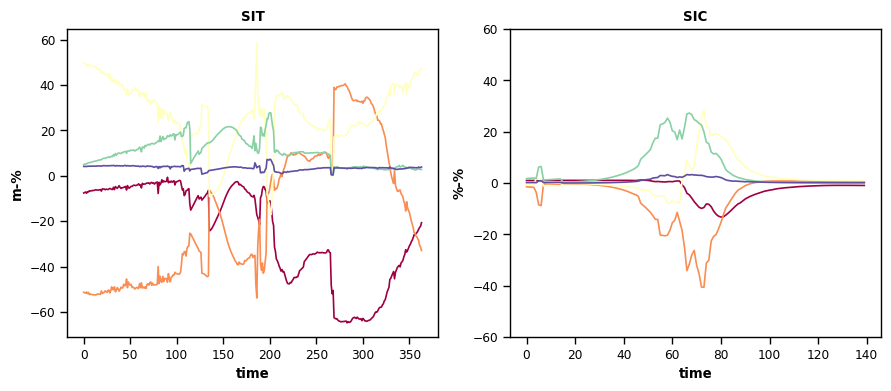

In [258]:
fig, axes = plt.subplots(ncols = 2, figsize=(9,4))
colors = plt.cm.get_cmap('Spectral', 5)


fore, infl, filt, post, em = open_data('SIT_f1_NORM_cice')
SIT_aicen = xr.cov(infl.hi, infl.aicen*100, dim = 'member', ddof = 1)/infl.hi.var(dim = 'member', ddof = 1)

for i in range(0,5):
    axes[0].plot(SIT_aicen[:,i], color = colors(i)[:3])

# axes[0].set_ylim([-0.3,0.3])

fore, infl, filt, post, em = open_data('SIC_f1_NORM_cice')
SIC_aicen = xr.cov(infl.aice, infl.aicen, dim = 'member', ddof = 1)/infl.aice.var(dim = 'member', ddof = 1)
    
for i in range(0,5):
    axes[1].plot(SIC_aicen[120:260,i], color = colors(i)[:3])
        
axes[1].set_ylim([-60, 60])


axes[0].set_title('SIT', fontweight = 'bold')
axes[1].set_title('SIC', fontweight = 'bold')
    
axes[0].set_xlabel('time', fontweight = 'bold')
axes[1].set_xlabel('time', fontweight = 'bold')

axes[0].set_ylabel('m-%', fontweight = 'bold')
axes[1].set_ylabel('%-%', fontweight = 'bold')

plt.tight_layout()

In [22]:
fore1, infl1, filt1, proc1, em1 = open_data('AIC_f1_NORM_catunwise')
fore2, infl2, filt2, proc2, em2 = open_data('AIC_f1_NORM_cice')

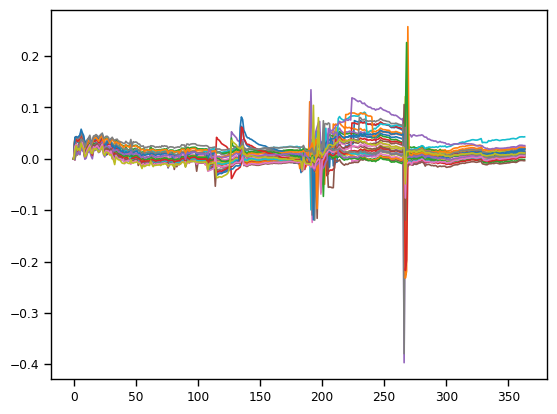

In [19]:
plt.plot(proc1.hi.transpose() - proc2.hi.transpose())

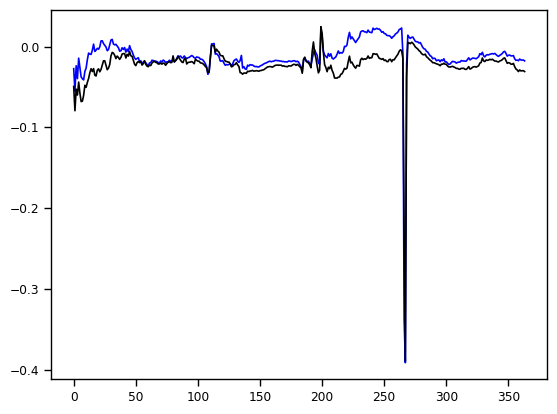

In [26]:
plt.plot(em1.hi.values.transpose() - data.isel({'member':13}).hi.values, color = 'blue', label = 'unwise')
plt.plot(em2.hi.values.transpose() - data.isel({'member':13}).hi.values, color = 'black', label = 'catwise')
# plt.plot(processed.aice - forecasted.aice[1:])
# plt.ylim([-0.02, 0.01])
# plt.xlim([300,350])

In [61]:
import numpy as np

In [67]:
forecasted.isel({'time':0})

<xarray.Dataset>
Dimensions:  (member: 29, ncat: 5)
Coordinates:
    time     object 2011-01-02 00:00:00
    ni       int32 3
  * ncat     (ncat) int32 1 2 3 4 5
Dimensions without coordinates: member
Data variables:
    aicen    (member, ncat) float64 0.07699 0.4739 0.269 ... 0.07694 0.09895
    vicen    (member, ncat) float64 0.02502 0.489 0.472 ... 0.5978 0.2433 0.7928
    vsnon    (member, ncat) float64 0.006388 0.1137 0.06992 ... 0.0197 0.02641
    aice     (member) float64 0.9969 0.997 0.997 0.9967 ... 0.9969 0.997 0.9965
    hi       (member) float64 2.01 1.937 2.236 1.962 ... 2.094 2.083 2.345 2.104

In [195]:
forecasted = forecasted.assign_coords({'member': np.arange(1,30)})

In [198]:
temp = forecasted.isel({'time':t+1}).aice.sortby(forecasted.isel({'time':t+1}).aice)

In [199]:
order = temp.member

In [72]:
Prob=np.arange(29)/float(29)

In [211]:
t = 240

In [100]:
plt.plot(forecasted.isel({'time':t+1}).aice.sortby(forecasted.isel({'time':t+1}).aice),Prob,marker = 'o', markersize=5, label = 'prior')
plt.plot(inflated.isel({'time':t}).aice.sortby(forecasted.isel({'time':t+1}).aice), Prob, marker = 'o', markersize=5, label = 'inflated prior')
plt.plot(filtered.isel({'time':t}).aice.sortby(forecasted.isel({'time':t+1}).aice), Prob, marker = 'o', markersize=5, label = 'filtered posterior')
plt.plot(processed.isel({'time':t}).aice.sortby(forecasted.isel({'time':t+1}).aice), Prob, marker = 'o', markersize=5, linewidth = 0.85, label = 'postprocessed posterior', linestyle = 'dashed')

plt.legend()
plt.tight_layout()

NameError: name 'forecasted' is not defined

In [158]:
temp = inflated.hi.values.transpose() - forecasted.hi.values[1:]

In [96]:
temp = inflated.std(dim='member') - forecasted.std(dim='member')

In [98]:
temp.hi

<xarray.DataArray 'hi' (time: 0)>
array([], dtype=float64)
Coordinates:
  * time     (time) object 
    ni       int32 3

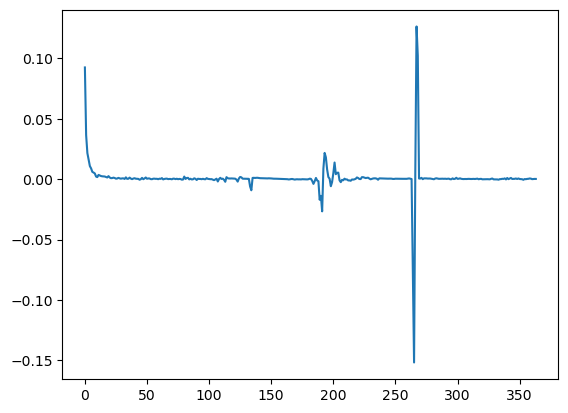

In [107]:
plt.plot(inflated.std(dim='member').hi.values - forecasted.std(dim='member').hi[1:].values)

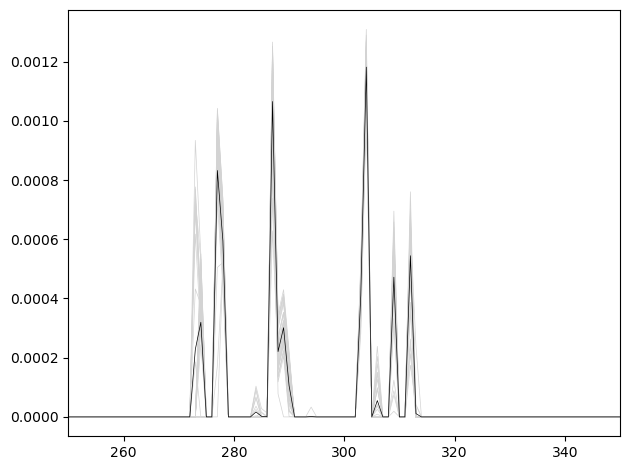

In [122]:
plt.plot(processed.hi.values.transpose() - filtered.hi.values.transpose(), color = 'lightgrey', linewidth = 0.5)
plt.plot(np.mean(processed.hi.values.transpose() - filtered.hi.values.transpose(), axis=1), color = 'black', linewidth = 0.5)
plt.xlim([250,350])
plt.tight_layout()

In [114]:
thing = processed1 - forecasted1.isel(time = slice(1,len(forecasted1.time)))

In [115]:
thing

<xarray.Dataset>
Dimensions:  (time: 364, ncat: 5, member: 29)
Coordinates:
  * time     (time) object 2011-01-03 00:00:00 ... 2012-01-01 00:00:00
  * ncat     (ncat) int64 1 2 3 4 5
    ni       int32 3
Dimensions without coordinates: member
Data variables:
    aicen    (member, time, ncat) float64 0.002597 -0.0008453 ... -0.0001086
    vicen    (member, time, ncat) float64 0.0005267 0.0002384 ... -0.0007481
    vsnon    (member, time, ncat) float64 -2.853e-05 -0.004828 ... -0.0001173
    aice     (member, time) float64 0.0002528 0.002892 ... 0.001671 0.001991
    hi       (member, time) float64 -0.00346 -0.01071 ... -0.01307 -0.009356

In [118]:
DJF = thing.groupby('time.season')['DJF']
MAM = thing.groupby('time.season')['MAM']
JJA = thing.groupby('time.season')['JJA']
SON = thing.groupby('time.season')['SON']

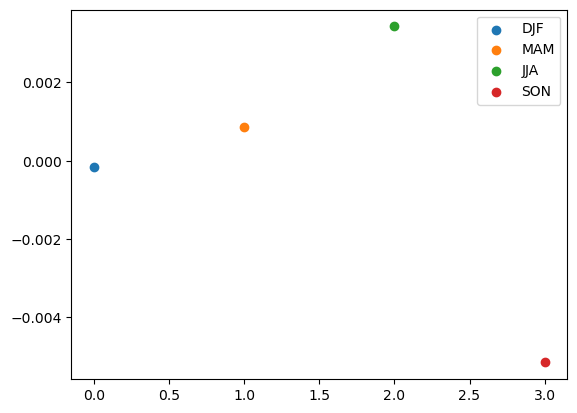

In [126]:
plt.scatter(x = 0, y = DJF.aice.mean(dim='member').mean(dim='time'), label = 'DJF')
plt.scatter(x = 1, y = MAM.aice.mean(dim='member').mean(dim='time'), label = 'MAM')
plt.scatter(x = 2, y = JJA.aice.mean(dim='member').mean(dim='time'), label = 'JJA')
plt.scatter(x = 3, y = SON.aice.mean(dim='member').mean(dim='time'), label = 'SON')
plt.legend()

In [15]:
data = open_data2('unassimilated')

In [16]:
fore, infl, filt, proc, em = open_data('SIT_f1_BNRH_vice')

In [17]:
mean = data.mean(dim='member')

In [15]:
mean

<xarray.Dataset>
Dimensions:  (time: 364, ncat: 5)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-02 2011-01-03 ... 2011-12-31
  * ncat     (ncat) int32 1 2 3 4 5
Data variables:
    aicen    (time, ncat) float64 0.08585 0.4977 0.2414 ... 0.07658 0.09567
    vicen    (time, ncat) float64 0.0294 0.5056 0.4238 ... 0.3947 0.2503 0.7409
    vsnon    (time, ncat) float64 0.007585 0.1122 0.0617 ... 0.02296 0.02966
    aice     (time) float64 0.9968 0.9961 0.9945 0.9966 ... 0.9973 0.996 0.9949
    hi       (time) float64 1.953 1.957 1.965 1.967 ... 1.92 1.926 1.935 1.943

In [18]:
thing = xr.cov(mean.aicen, mean.vsnon, dim = 'time', ddof = 1)/mean.aicen.var(dim='time', ddof = 1)

In [19]:
thing2 = xr.cov(infl.aicen.mean(dim='time'), infl.vsnon.mean(dim='time'), dim = 'member', ddof = 1)/infl.aicen.mean(dim='time').var(dim='member', ddof =1)

In [20]:
bars = [list(thing.values), list(thing2.values)]

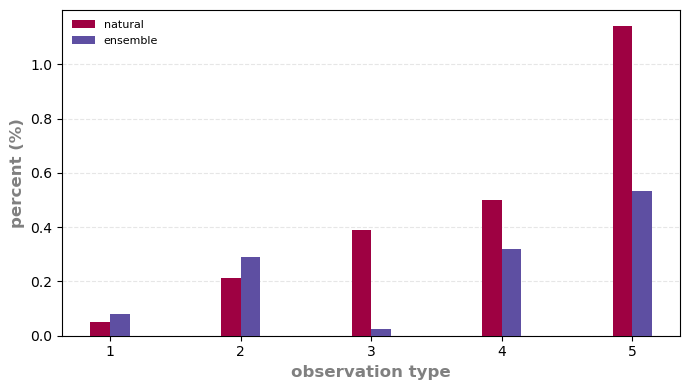

In [21]:
plt.figure(figsize=(7,4))
plt.grid(axis='y', color = '0.9', linestyle='dashed', zorder=0)
colors = plt.cm.get_cmap('Spectral', np.shape(bars)[0])

n = np.shape(bars)[0]
w = .15
x = np.arange(0, np.shape(bars)[1]) 
names = ['natural', 'ensemble']
cats = ['1', '2' ,'3', '4', '5']

for i in range(0, np.shape(bars)[0]):
    position = x + (w*(1-n)/2) + i*w
    plt.bar(position, bars[:][i], width = w, label = names[i], color = colors(i)[:3], zorder = 3)

plt.xticks(np.arange(0,np.shape(bars)[1]), labels = cats)
# plt.ylim([0,6])
plt.ylabel('percent (%)', fontweight='bold', fontsize=12, color = 'grey')
plt.xlabel('observation type', fontweight='bold', fontsize=12, color = 'grey')
plt.legend(fontsize=8, loc = 'upper left', frameon=False)
# plt.title('Percent of Filter Increments that Violated SIC Bounds', fontweight='bold', fontsize=12)

plt.tight_layout()

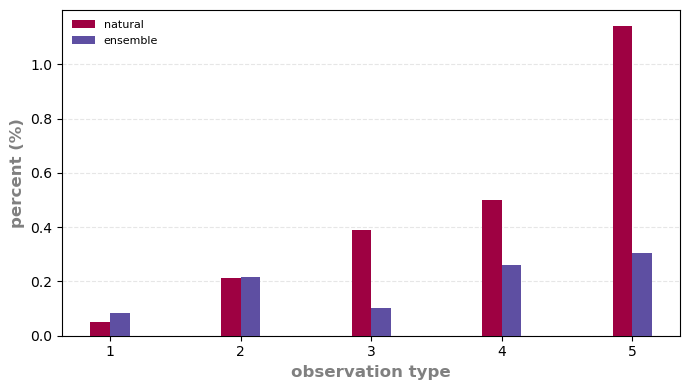

In [65]:
plt.figure(figsize=(7,4))
plt.grid(axis='y', color = '0.9', linestyle='dashed', zorder=0)
colors = plt.cm.get_cmap('Spectral', np.shape(bars)[0])

n = np.shape(bars)[0]
w = .15
x = np.arange(0, np.shape(bars)[1]) 
names = ['natural', 'ensemble']
cats = ['1', '2' ,'3', '4', '5']

for i in range(0, np.shape(bars)[0]):
    position = x + (w*(1-n)/2) + i*w
    plt.bar(position, bars[:][i], width = w, label = names[i], color = colors(i)[:3], zorder = 3)

plt.xticks(np.arange(0,np.shape(bars)[1]), labels = cats)
# plt.ylim([0,6])
plt.ylabel('percent (%)', fontweight='bold', fontsize=12, color = 'grey')
plt.xlabel('observation type', fontweight='bold', fontsize=12, color = 'grey')
plt.legend(fontsize=8, loc = 'upper left', frameon=False)
# plt.title('Percent of Filter Increments that Violated SIC Bounds', fontweight='bold', fontsize=12)

plt.tight_layout()

In [67]:
aggreg_obs = get_observations('/glade/work/mollyw/DA_obs/ICEPACK_OBS/free_SHEBA/eakf_vs_brhf/mem_14/bc_obs/', catwise=False)

In [73]:
hi_truth = aggreg_obs.truths[:,0]

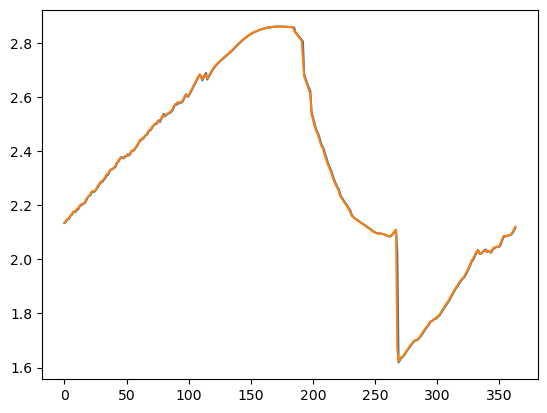

In [81]:
plt.plot(hi_truth)
plt.plot(hi_mod_truth)

In [86]:
hi_mod_truth = data.hi.isel({'member':13})

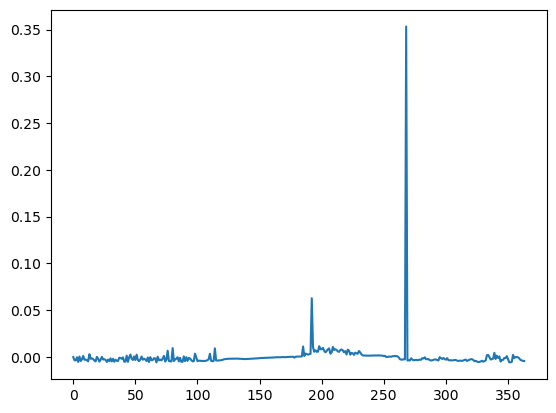

In [87]:
plt.plot(hi_truth - hi_mod_truth)

### Significance

In [125]:
import scipy.stats as stats
from matplotlib import colors

In [128]:
data = open_data2('unassimilated')
truth = data.isel({'member':13})

In [129]:
free = data.mean(dim = 'member')

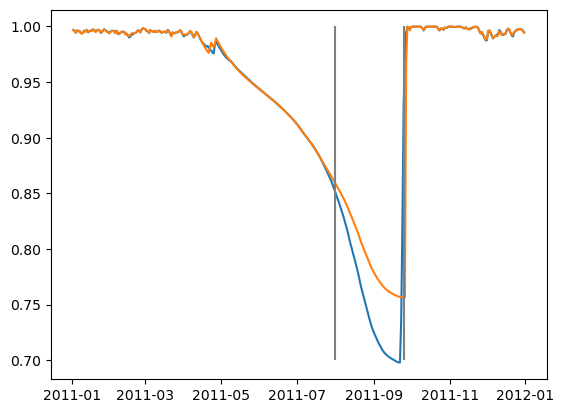

In [11]:
plt.plot(free.time, free.aice)
plt.plot(free.time, truth.aice)
plt.vlines(x='2011-08-01', ymin = 0.7, ymax = 1, color = 'grey')
plt.vlines(x='2011-09-25', ymin = 0.7, ymax = 1, color = 'grey')

In [122]:
case_list = ['SIT_f1_NORM_cice', 'SIT_f101_NORM_cice', 'SIT_f1_BNRH_cice', 'SIT_f101_BNRH_cice',
             'SIC_f1_NORM_cice', 'SIC_f101_NORM_cice', 'SIC_f1_BNRH_cice', 'SIC_f101_BNRH_cice',
             'AGR_f1_NORM_cice', 'AGR_f101_NORM_cice', 'AGR_f1_BNRH_cice', 'AGR_f101_BNRH_cice',
             'VIC_f1_NORM_cice', 'VIC_f101_NORM_cice', 'VIC_f1_BNRH_cice', 'VIC_f101_BNRH_cice',
             'AIC_f1_NORM_vice', 'AIC_f101_NORM_cice', 'AIC_f1_BNRH_cice', 'AIC_f101_BNRH_cice',
             'CAT_f1_NORM_cice', 'CAT_f101_NORM_cice', 'CAT_f1_BNRH_cice', 'CAT_f101_BNRH_cice',
            ]

In [30]:
em1

<xarray.Dataset>
Dimensions:  (time: 364, ncat: 5)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-02 2011-01-03 ... 2011-12-31
    ni       int32 3
  * ncat     (ncat) int32 1 2 3 4 5
Data variables:
    aicen    (time, ncat) float64 0.0749 0.4185 0.3179 ... 0.3129 0.07798 0.1015
    vicen    (time, ncat) float64 0.02428 0.4336 0.5666 ... 0.5537 0.2458 0.8276
    vsnon    (time, ncat) float64 0.005682 0.09508 0.08149 ... 0.02288 0.03065
    aice     (time) float64 0.9969 0.9961 0.9939 0.9961 ... 0.9971 0.9957 0.9948
    hi       (time) float64 2.106 2.126 2.137 2.158 ... 2.081 2.089 2.099 2.107

In [148]:
variable = 'aice'
FREE = []
TRUE = []
CASES = []
case_copy = case_list.copy()
for case in case_list:
    
    f, i, filt, p, em1 = open_data(case)
    
    # significance from free mean
    if variable == 'aice':
        FREE.append(stats.ttest_ind(em1.aice.sel(time=slice('2011-08-01','2011-10-01')), free.aice.sel(time=slice('2011-08-01','2011-10-01')), equal_var = False)[1])
    elif variable == 'snow':
        FREE.append(stats.ttest_ind(em1.vsnon.sel(time=slice('2011-08-01','2011-10-01')).sum(dim='ncat'), free.vsnon.sel(time=slice('2011-08-01','2011-10-01')).sum(dim='ncat'), equal_var = False)[1])
    else:
        FREE.append(stats.ttest_ind(em1[variable], free[variable], equal_var = False)[1])  
    
    # significance from truth
    if variable == 'aice':
        TRUE.append(stats.ttest_ind(em1.aice.sel(time=slice('2011-08-01','2011-10-01')), truth.aice.sel(time=slice('2011-08-01','2011-10-01')), equal_var = False)[1])
    elif variable == 'snow':
        TRUE.append(stats.ttest_ind(em1.vsnon.sel(time=slice('2011-08-01','2011-10-01')).sum(dim='ncat'), truth.vsnon.sel(time=slice('2011-08-01','2011-10-01')).sum(dim='ncat'), equal_var = False)[1])
    else:
        TRUE.append(stats.ttest_ind(em1[variable], truth[variable], equal_var = False)[1])  
    
    # significance from everything else
    CASE = []
    case_copy.remove(case)
    for case2 in case_copy: 
        f, i, filt, p, em2 = open_data(case2)
        if variable == 'aice':
            CASE.append(stats.ttest_ind(em2.aice.sel(time=slice('2011-08-01','2011-10-01')), em1.aice.sel(time=slice('2011-08-01','2011-10-01')), equal_var = False)[1])
        elif variable == 'snow':
            CASE.append(stats.ttest_ind(em2.vsnon.sel(time=slice('2011-08-01','2011-10-01')).sum(dim='ncat'), em1.vsnon.sel(time=slice('2011-08-01','2011-10-01')).sum(dim='ncat'), equal_var = False)[1])
        else:
            CASE.append(stats.ttest_ind(em2[variable], em1[variable], equal_var = False)[1])
            
    CASES.append(CASE)
    

In [149]:
empty = np.zeros((len(case_list), len(case_list)+2))

In [150]:
empty[:,-1] = FREE
empty[:,-2] = TRUE

In [151]:
for i in range(0, len(CASES)):
    empty[i,i+1:-2] = CASES[i]

In [152]:
thing = np.where(empty==0, np.nan, empty)
# thing = np.where(thing > 0.05, thing, thing)
# thing = np.where(thing == 0, 10, thing)

In [153]:
case_list2 = [case_list[i][:-5] for i in range(0, len(case_list))]

In [154]:
case_list2.append('TRUTH')
case_list2.append('FREE')

/glade/scratch/mollyw/ipykernel_208044/1967566513.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = case_list2, rotation = 90)


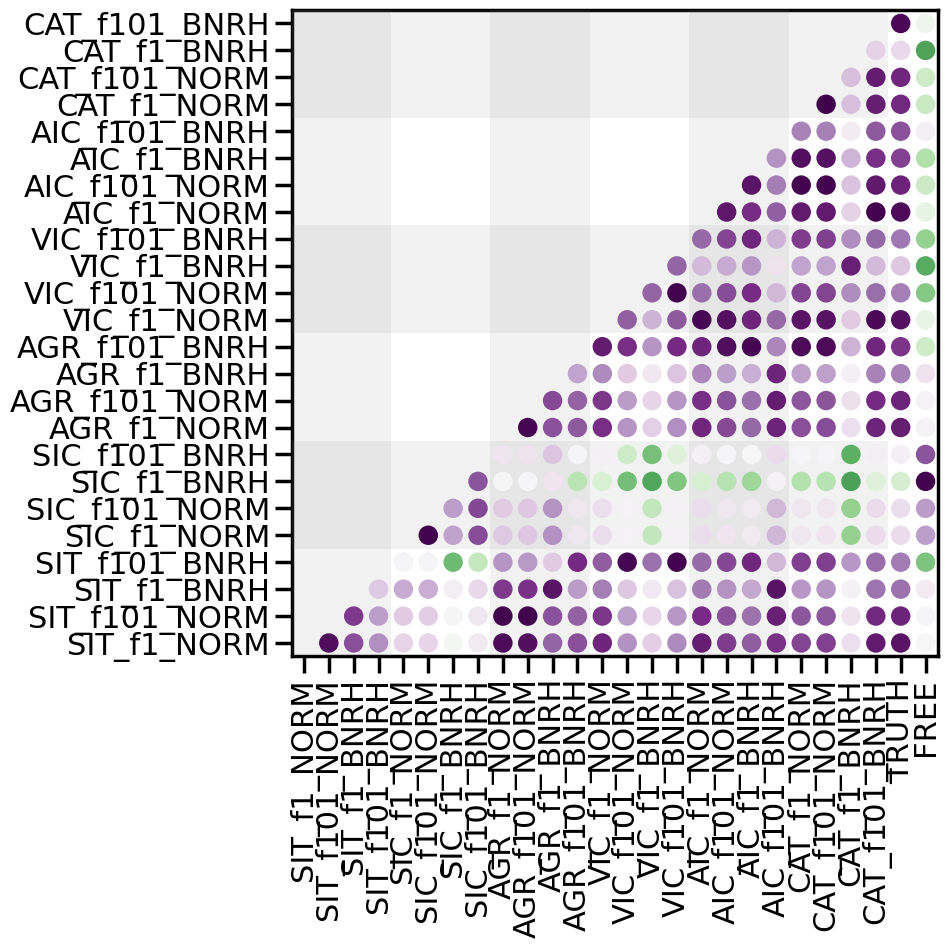

In [155]:
sns.set_context('poster')
divnorm=colors.TwoSlopeNorm(vmin=-0.025, vcenter=0.05, vmax=1)

fig, ax = plt.subplots(figsize=(10,10))
for i in range(0,len(thing)):
    ys = np.tile(case_list[i][:-5],np.shape(thing)[1])
    plt.scatter(x = case_list2, y = ys, c = thing[i,:], cmap = plt.cm.PRGn_r, norm=divnorm, zorder = 6)
# axes[2].fill_between(x, lowerbound.vsnon.sum(dim='ncat')*100, upperbound.vsnon.sum(dim='ncat')*100, alpha=0.2, color = colors[count], zorder = 3)
   
ax.fill_between(np.arange(0,len(thing)+1)-0.5, np.tile(3.5,len(thing)+1), np.tile(7.5,len(thing)+1), color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_between(np.arange(0,len(thing)+1)-0.5, np.tile(11.5,len(thing)+1), np.tile(15.5,len(thing)+1), color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_between(np.arange(0,len(thing)+1)-0.5, np.tile(19.5,len(thing)+1), np.tile(23.5,len(thing)+1), color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)

ax.fill_betweenx(np.arange(0,len(thing)+1)-0.5, -0.5, 3.5, color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_betweenx(np.arange(0,len(thing)+1)-0.5, 7.5, 11.5, color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)
ax.fill_betweenx(np.arange(0,len(thing)+1)-0.5, 15.5, 19.5, color = 'grey', alpha=0.1, edgecolor = None, zorder = 3)

ax.set_xticklabels(labels = case_list2, rotation = 90)
plt.ylim([-0.5,23.5])
plt.xlim([-0.5,25.5])
# plt.colorbar()
plt.tight_layout()